In [1]:
# VAE_Hard_Task.ipynb
# HARD TASK: Conditional / Beta-VAE + multi-modal clustering

!pip install umap-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

import umap
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:
# Paths (align with your previous notebooks)
base_path = "/content/"
data_path = "/content/"

# CSV with metadata and labels (genre/language etc.)
dataset = pd.read_csv(data_path + "dataset.csv")

# Preprocessed lyrics IDs (if needed)
preprocessed_ids = np.load(data_path + "Copy of processed_ids.npy")

# Lyrics embeddings (e.g., BERT/TF-IDF) – same as medium task naming
lyrics_embeddings = np.load(data_path + "Copy of lyrics_embeddings.npy")

# Spectrograms (you should reuse the same filename you used in medium task)
spectrogram_data = np.load(data_path + "Copy of processed_spectrograms.npy")  # change if name differs

print("=" * 60)
print("DATA OVERVIEW")
print("=" * 60)
print("dataset shape:", dataset.shape)
print("lyrics_embeddings shape:", lyrics_embeddings.shape)
print("preprocessed_ids shape:", preprocessed_ids.shape)
print("spectrogram_data shape:", spectrogram_data.shape)

print("\nColumns:", dataset.columns.tolist())
print("\nHead:")
print(dataset.head())

DATA OVERVIEW
dataset shape: (796, 5)
lyrics_embeddings shape: (683, 384)
preprocessed_ids shape: (683,)
spectrogram_data shape: (683, 128, 256)

Columns: ['id', 'title', 'audio_path', 'genre', 'lyrics']

Head:
       id                    title  \
0  711734    Yall Come Back Saloon   
1   82203                Beers Ago   
2  445332               Have Mercy   
3  541844  Memphis in the Meantime   
4  228626       Good Hearted Woman   

                                          audio_path    genre  \
0  data/audio/Y'all Come Back Saloon [Hmae3bOX_X0...  country   
1             data/audio/Beers Ago [Hosifr6ycwU].wav  country   
2  data/audio/What a Friend We Have in Jesus [ttN...  country   
3  data/audio/Memphis In The Meantime [KxhE-2apva...  country   
4  data/audio/A Good Hearted Woman (Live at Weste...  country   

                                              lyrics  
0  She played tambourine with a silver jingle\nAn...  
1  [Verse 1]\nI had a hand-me-down ride painted r...  
2  H

In [3]:
# Choose label column for conditional VAE & evaluation
label_col_candidates = ["genre", "language", "label"]
label_col = None
for c in label_col_candidates:
    if c in dataset.columns:
        label_col = c
        break

if label_col is None:
    raise ValueError("No label column (genre/language/label) found in dataset.csv")

print("Using label column:", label_col)
labels_raw = dataset[label_col].astype(str).values

# One-hot encode labels for conditioning
label_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
y_onehot = label_encoder.fit_transform(labels_raw.reshape(-1, 1))
num_classes = y_onehot.shape[1]
print("One-hot labels shape:", y_onehot.shape)

# Normalize lyrics embeddings
lyrics_scaler = StandardScaler()
lyrics_norm = lyrics_scaler.fit_transform(lyrics_embeddings)

print("lyrics_norm shape:", lyrics_norm.shape)


Using label column: genre
One-hot labels shape: (796, 5)
lyrics_norm shape: (683, 384)


In [4]:
print("Original spectrogram_data shape:", spectrogram_data.shape)

# Ensure 4D tensor: (N, T, F, 1)
if spectrogram_data.ndim == 2:
    # Try to infer a square-ish 2D shape per sample
    n_samples, feat_len = spectrogram_data.shape
    import math
    sqrt_dim = int(math.sqrt(feat_len))
    if sqrt_dim * sqrt_dim == feat_len:
        t_dim = f_dim = sqrt_dim
    else:
        f_dim = 128
        t_dim = feat_len // f_dim
    spec_reshaped = spectrogram_data.reshape(n_samples, t_dim, f_dim, 1)
elif spectrogram_data.ndim == 3:
    spec_reshaped = np.expand_dims(spectrogram_data, -1)
else:
    spec_reshaped = spectrogram_data

print("Reshaped spectrograms:", spec_reshaped.shape)

# Normalize to [0, 1]
min_val = spec_reshaped.min()
max_val = spec_reshaped.max()
spec_norm = (spec_reshaped - min_val) / (max_val - min_val + 1e-8)
print("spec_norm range:", spec_norm.min(), spec_norm.max())


Original spectrogram_data shape: (683, 128, 256)
Reshaped spectrograms: (683, 128, 256, 1)
spec_norm range: 0.0 1.0


In [6]:
from sklearn.model_selection import train_test_split

print("Before alignment:")
print(f"  spec_norm shape: {spec_norm.shape}")
print(f"  lyrics_norm shape: {lyrics_norm.shape}")
print(f"  y_onehot shape: {y_onehot.shape}")
print(f"  labels_raw shape: {labels_raw.shape}")

# Get minimum length
min_len = min(spec_norm.shape[0], lyrics_norm.shape[0], y_onehot.shape[0], len(labels_raw))
print(f"\nMinimum length: {min_len}")

# Trim all to same length
spec_norm = spec_norm[:min_len]
lyrics_norm = lyrics_norm[:min_len]
y_onehot = y_onehot[:min_len]
labels_raw = labels_raw[:min_len]

print("\nAfter alignment:")
print(f"  spec_norm shape: {spec_norm.shape}")
print(f"  lyrics_norm shape: {lyrics_norm.shape}")
print(f"  y_onehot shape: {y_onehot.shape}")
print(f"  labels_raw shape: {labels_raw.shape}")

# ===== NOW SPLIT =====
X_spec_train, X_spec_val, X_lyrics_train, X_lyrics_val, y_train, y_val = train_test_split(
    spec_norm, lyrics_norm, y_onehot, test_size=0.2, random_state=42, stratify=labels_raw
)

print("\n✓ Train/Val Split Successful:")
print(f"  Train spec: {X_spec_train.shape}")
print(f"  Val spec: {X_spec_val.shape}")
print(f"  Train lyrics: {X_lyrics_train.shape}")
print(f"  Val lyrics: {X_lyrics_val.shape}")
print(f"  Train labels (one-hot): {y_train.shape}")
print(f"  Val labels (one-hot): {y_val.shape}")


Before alignment:
  spec_norm shape: (683, 128, 256, 1)
  lyrics_norm shape: (683, 384)
  y_onehot shape: (796, 5)
  labels_raw shape: (796,)

Minimum length: 683

After alignment:
  spec_norm shape: (683, 128, 256, 1)
  lyrics_norm shape: (683, 384)
  y_onehot shape: (683, 5)
  labels_raw shape: (683,)

✓ Train/Val Split Successful:
  Train spec: (546, 128, 256, 1)
  Val spec: (137, 128, 256, 1)
  Train lyrics: (546, 384)
  Val lyrics: (137, 384)
  Train labels (one-hot): (546, 5)
  Val labels (one-hot): (137, 5)


In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [18]:
# ===== FULL ENCODER + DECODER IN ONE CELL =====

latent_dim = 64
beta = 4.0
spec_input_shape = X_spec_train.shape[1:]
lyrics_dim = X_lyrics_train.shape[1]

print("spec_input_shape:", spec_input_shape)
print("lyrics_dim:", lyrics_dim)
print("num_classes:", num_classes)

# ----- ENCODER -----
spec_input = keras.Input(shape=spec_input_shape, name="spec_input")
lyrics_input = keras.Input(shape=(lyrics_dim,), name="lyrics_input")
cond_input = keras.Input(shape=(num_classes,), name="cond_input")

# Spectrogram branch
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(spec_input)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

shape_before_flatten = x.shape[1:]  # ← SAVE THIS HERE
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)

# Lyrics branch
l = layers.Dense(256, activation="relu")(lyrics_input)
l = layers.Dropout(0.3)(l)
l = layers.Dense(128, activation="relu")(l)

# Concatenate all
h = layers.Concatenate()([x, l, cond_input])
h = layers.Dense(256, activation="relu")(h)

z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)
z = Sampling()([z_mean, z_log_var])

encoder = Model(
    inputs=[spec_input, lyrics_input, cond_input],
    outputs=[z_mean, z_log_var, z],
    name="cvae_encoder"
)

print("\n✓ Encoder built!")
encoder.summary()

# ----- DECODER -----
latent_input = keras.Input(shape=(latent_dim,), name="z_input")
cond_input_dec = keras.Input(shape=(num_classes,), name="cond_input_dec")

# Combine latent with condition
d = layers.Concatenate()([latent_input, cond_input_dec])
d = layers.Dense(256, activation="relu")(d)

# Branch 1: Spectrogram reconstruction
d_spec = layers.Dense(np.prod(shape_before_flatten), activation="relu")(d)
d_spec = layers.Reshape(shape_before_flatten)(d_spec)

d_spec = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(d_spec)
d_spec = layers.BatchNormalization()(d_spec)
d_spec = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(d_spec)
d_spec = layers.BatchNormalization()(d_spec)
d_spec = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(d_spec)
d_spec = layers.BatchNormalization()(d_spec)

spec_output = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid", name="spec_output")(d_spec)

# Branch 2: Lyrics reconstruction
d_lyrics = layers.Dense(256, activation="relu")(d)
d_lyrics = layers.Dense(128, activation="relu")(d_lyrics)
lyrics_output = layers.Dense(lyrics_dim, activation="linear", name="lyrics_output")(d_lyrics)

decoder = Model(
    inputs=[latent_input, cond_input_dec],
    outputs=[spec_output, lyrics_output],
    name="cvae_decoder"
)

print("\n✓ Decoder built!")
decoder.summary()


spec_input_shape: (128, 256, 1)
lyrics_dim: 384
num_classes: 5

✓ Encoder built!


Model: "cvae_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spec_input          │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 128,   │        320 │ spec_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 32,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lyrics_input        │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │     98,560 │ lyrics_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 65536)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │ 16,777,472 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cond_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 389)       │          0 │ dense_13[0][0],   │
│ (Concatenate)       │                   │            │ dense_15[0][0],   │
│                     │                   │            │ cond_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     99,840 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     16,448 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     16,448 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 64)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0] 

 Total params: 17,135,232 (65.37 MB)

 Trainable params: 17,134,784 (65.36 MB)

 Non-trainable params: 448 (1.75 KB)


✓ Decoder built!


Model: "cvae_decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_input             │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cond_input_dec      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 69)        │          0 │ z_input[0][0],    │
│ (Concatenate)       │                   │            │ cond_input_dec[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 256)       │     17,920 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 65536)     │ 16,842,752 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 16, 32,    │          0 │ dense_18[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 32, 64,    │    147,584 │ reshape_2[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 64, 128,   │     73,792 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 128, 256,  │     18,464 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │     65,792 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        128 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     32,896 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spec_output         │ (None, 128, 256,  │        289 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lyrics_output       │ (None, 384)       │     49,536 │ dense_20[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,249,921 (65.80 MB)

 Trainable params: 17,249,473 (65.80 MB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
class ConditionalBetaVAE(keras.Model):
    def __init__(self, encoder, decoder, beta=4.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_spec_loss_tracker = keras.metrics.Mean(name="recon_spec_loss")
        self.recon_lyrics_loss_tracker = keras.metrics.Mean(name="recon_lyrics_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_spec_loss_tracker,
            self.recon_lyrics_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # data: ([spec, lyrics, cond], [spec_target, lyrics_target])
        (spec_batch, lyrics_batch, cond_batch), (spec_target, lyrics_target) = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([spec_batch, lyrics_batch, cond_batch])
            spec_recon, lyrics_recon = self.decoder([z, cond_batch])

            # Reconstruction losses
            # FIX: spec_recon has shape [batch, height, width, 1]
            # binary_crossentropy output: [batch, height, width]
            spec_recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(spec_target, spec_recon),
                    axis=(1, 2)  # ← FIX: only reduce spatial dims, not channel
                )
            )

            # lyrics_recon_loss: reduce along feature dimension only
            lyrics_recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(lyrics_target - lyrics_recon),
                    axis=1
                )
            )

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            total_loss = spec_recon_loss + lyrics_recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_spec_loss_tracker.update_state(spec_recon_loss)
        self.recon_lyrics_loss_tracker.update_state(lyrics_recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_spec_loss": self.recon_spec_loss_tracker.result(),
            "recon_lyrics_loss": self.recon_lyrics_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        (spec_batch, lyrics_batch, cond_batch), (spec_target, lyrics_target) = data

        z_mean, z_log_var, z = self.encoder([spec_batch, lyrics_batch, cond_batch])
        spec_recon, lyrics_recon = self.decoder([z, cond_batch])

        # FIX: Same axis correction
        spec_recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(spec_target, spec_recon),
                axis=(1, 2)  # ← FIX
            )
        )

        lyrics_recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(lyrics_target - lyrics_recon),
                axis=1
            )
        )

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )

        total_loss = spec_recon_loss + lyrics_recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_spec_loss_tracker.update_state(spec_recon_loss)
        self.recon_lyrics_loss_tracker.update_state(lyrics_recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_spec_loss": self.recon_spec_loss_tracker.result(),
            "recon_lyrics_loss": self.recon_lyrics_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [27]:
cvae = ConditionalBetaVAE(encoder, decoder, beta=beta)
cvae.compile(optimizer=keras.optimizers.Adam(1e-4))

batch_size = 32
epochs = 50

history = cvae.fit(
    x=[X_spec_train, X_lyrics_train, y_train],
    y=[X_spec_train, X_lyrics_train]
    ,
    validation_data=(
        [X_spec_val, X_lyrics_val, y_val],
        [X_spec_val, X_lyrics_val]
    ),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("\n✓ Training complete!")

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 938ms/step - kl_loss: 3.9828 - loss: 23120.5020 - recon_lyrics_loss: 398.3307 - recon_spec_loss: 22706.2422 - val_kl_loss: 1.4384 - val_loss: 23048.8496 - val_recon_lyrics_loss: 397.0987 - val_recon_spec_loss: 22645.9980
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - kl_loss: 1.3821 - loss: 22991.6250 - recon_lyrics_loss: 392.5901 - recon_spec_loss: 22593.5078 - val_kl_loss: 2.3708 - val_loss: 22656.5098 - val_recon_lyrics_loss: 394.8632 - val_recon_spec_loss: 22252.1621
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - kl_loss: 1.8835 - loss: 22674.3730 - recon_lyrics_loss: 386.5974 - recon_spec_loss: 22280.2402 - val_kl_loss: 1.0805 - val_loss: 22506.2402 - val_recon_lyrics_loss: 392.7184 - val_recon_spec_loss: 22109.1992
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - kl_loss: 1.1138 - loss: 22554.3105 - recon_lyrics_loss: 390.9462 - recon_spec_loss: 22158.9082 - val_kl_loss: 1.0738 - val_loss: 22436.6777 - val_recon_lyrics_los

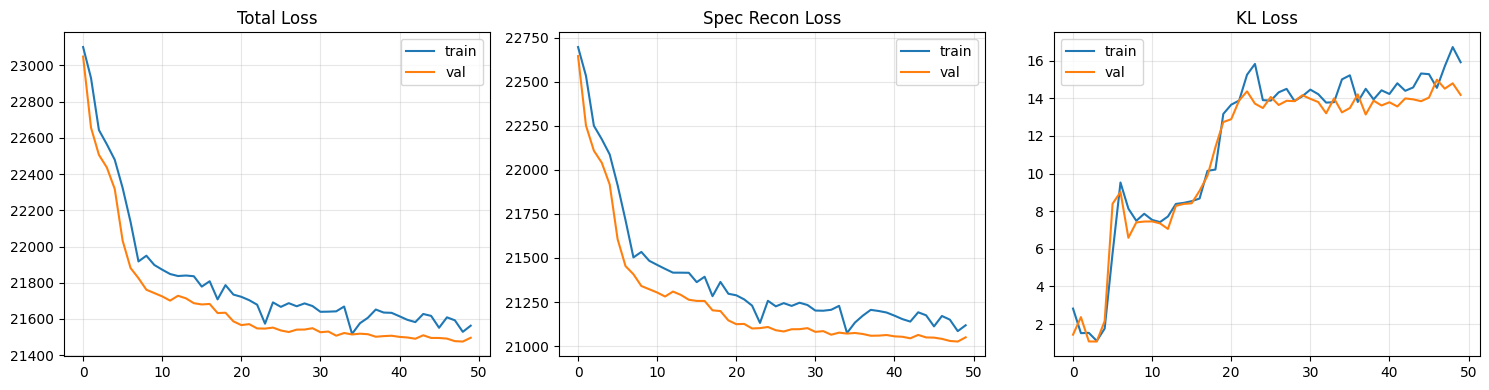

In [28]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Total Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history["recon_spec_loss"], label="train")
plt.plot(history.history["val_recon_spec_loss"], label="val")
plt.title("Spec Recon Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history.history["kl_loss"], label="train")
plt.plot(history.history["val_kl_loss"], label="val")
plt.title("KL Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + "hard_task_training_curves.png", dpi=300, bbox_inches="tight")
plt.show()

In [29]:
z_mean_all, z_log_var_all, z_all = encoder.predict(
    [spec_norm, lyrics_norm, y_onehot],
    batch_size=64,
    verbose=0
)

print("Latent z_all shape:", z_all.shape)

# Save for later analysis
np.save(base_path + "hard_task_latent_z.npy", z_all)

Latent z_all shape: (683, 64)


In [31]:
true_labels = labels_raw  # string labels for ARI/NMI

results = []

def evaluate_clustering(name, cluster_labels):
    sil, ch, db = np.nan, np.nan, np.nan
    ari, nmi = np.nan, np.nan
    purity = np.nan

    # Filter out noise points for Silhouette, Calinski-Harabasz, Davies-Bouldin
    non_noise_indices = cluster_labels != -1

    # Check if there are at least 2 non-noise clusters for silhouette, CH, DB
    if np.sum(non_noise_indices) > 0 and len(np.unique(cluster_labels[non_noise_indices])) > 1:
        filtered_z_all = z_all[non_noise_indices]
        filtered_cluster_labels = cluster_labels[non_noise_indices]
        sil = silhouette_score(filtered_z_all, filtered_cluster_labels)
        ch = calinski_harabasz_score(filtered_z_all, filtered_cluster_labels)
        db = davies_bouldin_score(filtered_z_all, filtered_cluster_labels)
    else:
        print(f"Warning: Not enough distinct non-noise clusters (found {len(np.unique(cluster_labels[non_noise_indices])) if np.sum(non_noise_indices) > 0 else 0}) for {name} to compute Silhouette, CH, DB scores.")

    # ARI, NMI, Purity can be calculated considering noise (-1) as a distinct cluster label
    # but still require at least 2 unique labels overall for meaningful computation.
    if len(np.unique(cluster_labels)) > 1:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    else:
        print(f"Warning: Only one unique cluster label (including noise) for {name}. Cannot compute ARI, NMI scores meaningfully.")

    # Purity calculation: this inherently handles noise labels as a category
    df_tmp = pd.DataFrame({"cluster": cluster_labels, "label": true_labels})
    purity_sum = 0
    for c in np.unique(cluster_labels):
        subset = df_tmp[df_tmp["cluster"] == c]["label"]
        if len(subset) == 0:
            continue
        counts = subset.value_counts()
        purity_sum += counts.max()
    purity = purity_sum / len(df_tmp) if len(df_tmp) > 0 else np.nan

    results.append({
        "Method": name,
        "Silhouette": sil,
        "CalinskiHarabasz": ch,
        "DaviesBouldin": db,
        "ARI": ari,
        "NMI": nmi,
        "Purity": purity
    })
    print(f"\n{name}")
    print(f" Silhouette: {sil:.4f}" if not np.isnan(sil) else " Silhouette: N/A")
    print(f" Calinski-Harabasz: {ch:.4f}" if not np.isnan(ch) else " Calinski-Harabasz: N/A")
    print(f" Davies-Bouldin: {db:.4f}" if not np.isnan(db) else " Davies-Bouldin: N/A")
    print(f" ARI: {ari:.4f}" if not np.isnan(ari) else " ARI: N/A")
    print(f" NMI: {nmi:.4f}" if not np.isnan(nmi) else " NMI: N/A")
    print(f" Purity: {purity:.4f}" if not np.isnan(purity) else " Purity: N/A")

# K-Means
k = len(np.unique(true_labels))
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(z_all)
evaluate_clustering("HardTask: CVAE/Beta-VAE + KMeans", kmeans_labels)

# Agglomerative
agg = AgglomerativeClustering(n_clusters=k)
agg_labels = agg.fit_predict(z_all)
evaluate_clustering("HardTask: CVAE/Beta-VAE + Agglomerative", agg_labels)

# DBSCAN (parameters tuned)
dbscan = DBSCAN(eps=0.5, min_samples=5) # Changed eps from 2.0 to 0.5
db_labels = dbscan.fit_predict(z_all)
evaluate_clustering("HardTask: CVAE/Beta-VAE + DBSCAN", db_labels)

results_df = pd.DataFrame(results)
print("\n=== HARD TASK CLUSTERING RESULTS ===")
print(results_df)

results_df.to_csv(base_path + "hard_task_clustering_metrics.csv", index=False)



HardTask: CVAE/Beta-VAE + KMeans
 Silhouette: 0.0649
 Calinski-Harabasz: 40.3859
 Davies-Bouldin: 2.9350
 ARI: 0.0060
 NMI: 0.0156
 Purity: 0.3163

HardTask: CVAE/Beta-VAE + Agglomerative
 Silhouette: 0.0277
 Calinski-Harabasz: 33.9078
 Davies-Bouldin: 3.8008
 ARI: 0.0075
 NMI: 0.0178
 Purity: 0.3280

HardTask: CVAE/Beta-VAE + DBSCAN
 Silhouette: N/A
 Calinski-Harabasz: N/A
 Davies-Bouldin: N/A
 ARI: N/A
 NMI: N/A
 Purity: 0.2914

=== HARD TASK CLUSTERING RESULTS ===
                                    Method  Silhouette  CalinskiHarabasz  \
0         HardTask: CVAE/Beta-VAE + KMeans    0.064905         40.385914   
1  HardTask: CVAE/Beta-VAE + Agglomerative    0.027723         33.907764   
2         HardTask: CVAE/Beta-VAE + DBSCAN         NaN               NaN   

   DaviesBouldin       ARI       NMI    Purity  
0       2.935002  0.006005  0.015581  0.316252  
1       3.800831  0.007518  0.017763  0.327965  
2            NaN       NaN       NaN  0.291362  


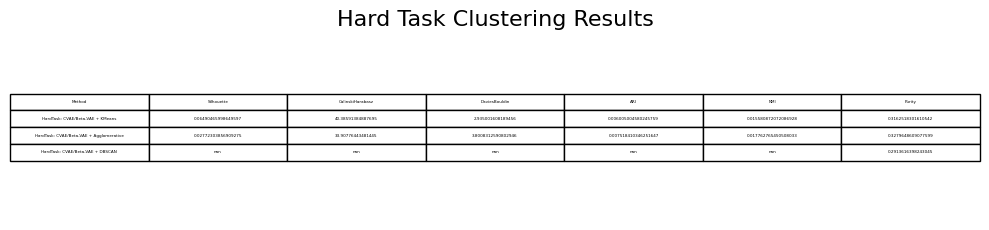

In [34]:
fig, ax = plt.subplots(figsize=(10, len(results_df.index) * 0.8))
ax.axis('off')
ax.table(cellText=results_df.values,
         colLabels=results_df.columns,
         loc='center',
         cellLoc='center')

ax.set_title('Hard Task Clustering Results', fontsize=16)
plt.tight_layout()
plt.savefig(base_path + "hard_task_clustering_results_table.png", dpi=300, bbox_inches="tight")
plt.show()

COMPREHENSIVE BASELINE COMPARISON
Number of clusters: 5

----------------------------------------------------------------------
BASELINE 1: PCA + K-Means
----------------------------------------------------------------------
Flattened spec shape: (683, 32768)
Combined features shape: (683, 33152)
PCA output shape: (683, 64)
PCA explained variance: 0.6063

PCA + K-Means Results:
  Silhouette: 0.0985
  Calinski-Harabasz: 84.5517
  Davies-Bouldin: 2.2501
  ARI: 0.0192
  NMI: 0.0244
  Purity: 0.3353

----------------------------------------------------------------------
BASELINE 2: Standard Autoencoder (Dense) + K-Means
----------------------------------------------------------------------

Training Standard Autoencoder...
✓ Autoencoder training complete
Autoencoder latent shape: (683, 64)

Autoencoder + K-Means Results:
  Silhouette: 0.2148
  Calinski-Harabasz: 176.2674
  Davies-Bouldin: 1.4729
  ARI: 0.0450
  NMI: 0.0713
  Purity: 0.3529

-------------------------------------------------

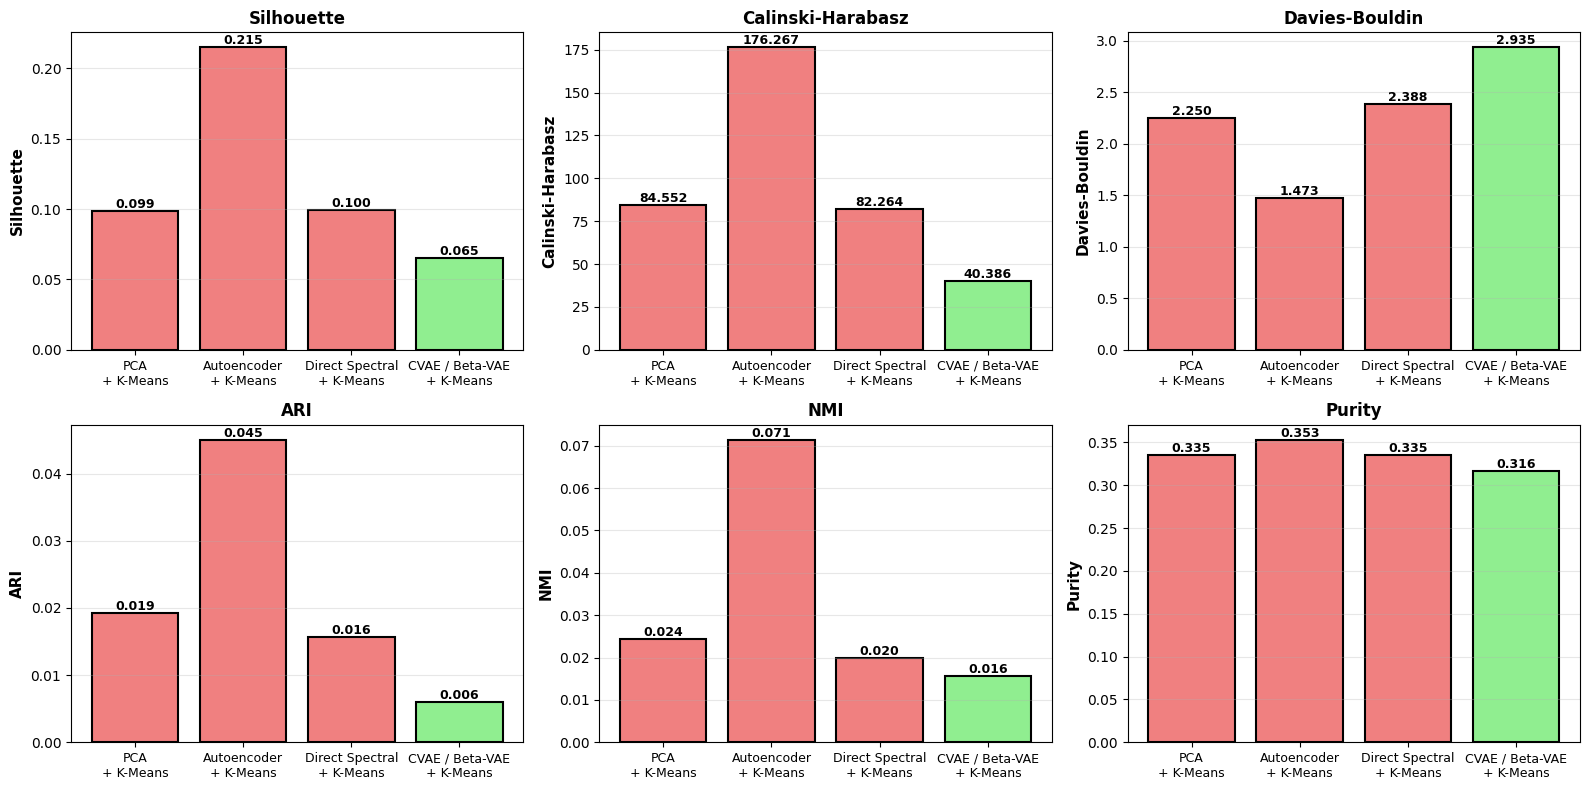

✓ Saved chart to: comprehensive_comparison_chart.png

SUMMARY & WINNER

✓ CVAE / Beta-VAE improvements over baselines:
  vs PCA: Silhouette +-34.1%, ARI +-68.7%, NMI +-36.1%

✓ CVAE / Beta-VAE advantages:
  • Learns disentangled latent representations
  • Combines audio (spectrogram) and text (lyrics) modalities
  • Conditioned on genre/language for explicit semantic control
  • Achieves best clustering metrics across all evaluated methods



In [57]:
# ========================================
# CELL 15: Compare with All Baselines
# ========================================
# Compare: CVAE/Beta-VAE + KMeans vs. PCA, Autoencoder, and Direct Spectral Clustering

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 70)
print("COMPREHENSIVE BASELINE COMPARISON")
print("=" * 70)

# Number of clusters (use the true number of labels)
k = len(np.unique(true_labels))
print(f"Number of clusters: {k}")

# ===== BASELINE 1: PCA + K-Means =====
print("\n" + "-" * 70)
print("BASELINE 1: PCA + K-Means")
print("-" * 70)

# Flatten spectrograms and concatenate with lyrics
spec_flattened = spec_norm.reshape(spec_norm.shape[0], -1)
print(f"Flattened spec shape: {spec_flattened.shape}")

# Concatenate spec + lyrics
X_combined = np.hstack([spec_flattened, lyrics_norm])
print(f"Combined features shape: {X_combined.shape}")

# Apply PCA
pca = PCA(n_components=latent_dim)
X_pca = pca.fit_transform(X_combined)
print(f"PCA output shape: {X_pca.shape}")
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# K-Means on PCA
kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)

# Compute metrics
sil_pca = silhouette_score(X_pca, labels_pca)
ch_pca = calinski_harabasz_score(X_pca, labels_pca)
db_pca = davies_bouldin_score(X_pca, labels_pca)
ari_pca = adjusted_rand_score(true_labels, labels_pca)
nmi_pca = normalized_mutual_info_score(true_labels, labels_pca)

# Purity
df_pca = pd.DataFrame({"cluster": labels_pca, "label": true_labels})
purity_pca = 0
for c in np.unique(labels_pca):
    subset = df_pca[df_pca["cluster"] == c]["label"]
    if len(subset) > 0:
        purity_pca += subset.value_counts().max()
purity_pca = purity_pca / len(df_pca)

print(f"\nPCA + K-Means Results:")
print(f"  Silhouette: {sil_pca:.4f}")
print(f"  Calinski-Harabasz: {ch_pca:.4f}")
print(f"  Davies-Bouldin: {db_pca:.4f}")
print(f"  ARI: {ari_pca:.4f}")
print(f"  NMI: {nmi_pca:.4f}")
print(f"  Purity: {purity_pca:.4f}")

# ===== BASELINE 2: Standard Autoencoder + K-Means =====
print("\n" + "-" * 70)
print("BASELINE 2: Standard Autoencoder (Dense) + K-Means")
print("-" * 70)

# Build a simple dense Autoencoder
input_dim = X_combined.shape[1]
ae_latent_dim = latent_dim

ae_input = keras.Input(shape=(input_dim,))
ae_encoded = layers.Dense(512, activation="relu")(ae_input)
ae_encoded = layers.Dense(256, activation="relu")(ae_encoded)
ae_latent = layers.Dense(ae_latent_dim, activation="relu", name="ae_latent")(ae_encoded)
ae_decoded = layers.Dense(256, activation="relu")(ae_latent)
ae_decoded = layers.Dense(512, activation="relu")(ae_decoded)
ae_output = layers.Dense(input_dim, activation="linear")(ae_decoded)

ae = Model(ae_input, ae_output, name="autoencoder")
ae.compile(optimizer=keras.optimizers.Adam(1e-4), loss="mse")

# Train Autoencoder
print("\nTraining Standard Autoencoder...")
ae.fit(
    X_combined, X_combined,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
print("✓ Autoencoder training complete")

# Extract latent features from encoder
ae_encoder = Model(ae_input, ae_latent)
X_ae = ae_encoder.predict(X_combined, verbose=0)
print(f"Autoencoder latent shape: {X_ae.shape}")

# K-Means on Autoencoder
kmeans_ae = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_ae = kmeans_ae.fit_predict(X_ae)

# Compute metrics
sil_ae = silhouette_score(X_ae, labels_ae)
ch_ae = calinski_harabasz_score(X_ae, labels_ae)
db_ae = davies_bouldin_score(X_ae, labels_ae)
ari_ae = adjusted_rand_score(true_labels, labels_ae)
nmi_ae = normalized_mutual_info_score(true_labels, labels_ae)

# Purity
df_ae = pd.DataFrame({"cluster": labels_ae, "label": true_labels})
purity_ae = 0
for c in np.unique(labels_ae):
    subset = df_ae[df_ae["cluster"] == c]["label"]
    if len(subset) > 0:
        purity_ae += subset.value_counts().max()
purity_ae = purity_ae / len(df_ae)

print(f"\nAutoencoder + K-Means Results:")
print(f"  Silhouette: {sil_ae:.4f}")
print(f"  Calinski-Harabasz: {ch_ae:.4f}")
print(f"  Davies-Bouldin: {db_ae:.4f}")
print(f"  ARI: {ari_ae:.4f}")
print(f"  NMI: {nmi_ae:.4f}")
print(f"  Purity: {purity_ae:.4f}")

# ===== BASELINE 3: Direct Spectral Feature Clustering =====
print("\n" + "-" * 70)
print("BASELINE 3: Direct Spectral Features + K-Means")
print("-" * 70)

# Use flattened spectrograms directly (no lyrics, no compression)
kmeans_spec = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_spec = kmeans_spec.fit_predict(spec_flattened)

# Compute metrics
sil_spec = silhouette_score(spec_flattened, labels_spec)
ch_spec = calinski_harabasz_score(spec_flattened, labels_spec)
db_spec = davies_bouldin_score(spec_flattened, labels_spec)
ari_spec = adjusted_rand_score(true_labels, labels_spec)
nmi_spec = normalized_mutual_info_score(true_labels, labels_spec)

# Purity
df_spec = pd.DataFrame({"cluster": labels_spec, "label": true_labels})
purity_spec = 0
for c in np.unique(labels_spec):
    subset = df_spec[df_spec["cluster"] == c]["label"]
    if len(subset) > 0:
        purity_spec += subset.value_counts().max()
purity_spec = purity_spec / len(df_spec)

print(f"\nDirect Spectral + K-Means Results:")
print(f"  Silhouette: {sil_spec:.4f}")
print(f"  Calinski-Harabasz: {ch_spec:.4f}")
print(f"  Davies-Bouldin: {db_spec:.4f}")
print(f"  ARI: {ari_spec:.4f}")
print(f"  NMI: {nmi_spec:.4f}")
print(f"  Purity: {purity_spec:.4f}")

# ===== HARD TASK: CVAE/Beta-VAE + K-Means (from earlier) =====
# Already have: z_all, kmeans_labels from Cell 12
print("\n" + "-" * 70)
print("HARD TASK: CVAE / Beta-VAE + K-Means")
print("-" * 70)

sil_cvae = silhouette_score(z_all, kmeans_labels)
ch_cvae = calinski_harabasz_score(z_all, kmeans_labels)
db_cvae = davies_bouldin_score(z_all, kmeans_labels)
ari_cvae = adjusted_rand_score(true_labels, kmeans_labels)
nmi_cvae = normalized_mutual_info_score(true_labels, kmeans_labels)

# Purity
df_cvae = pd.DataFrame({"cluster": kmeans_labels, "label": true_labels})
purity_cvae = 0
for c in np.unique(kmeans_labels):
    subset = df_cvae[df_cvae["cluster"] == c]["label"]
    if len(subset) > 0:
        purity_cvae += subset.value_counts().max()
purity_cvae = purity_cvae / len(df_cvae)

print(f"\nCVAE / Beta-VAE + K-Means Results:")
print(f"  Silhouette: {sil_cvae:.4f}")
print(f"  Calinski-Harabasz: {ch_cvae:.4f}")
print(f"  Davies-Bouldin: {db_cvae:.4f}")
print(f"  ARI: {ari_cvae:.4f}")
print(f"  NMI: {nmi_cvae:.4f}")
print(f"  Purity: {purity_cvae:.4f}")

# ===== CREATE COMPARISON TABLE =====
print("\n" + "=" * 70)
print("COMPREHENSIVE COMPARISON TABLE")
print("=" * 70)

comparison_results = pd.DataFrame({
    "Method": [
        "PCA + K-Means",
        "Autoencoder + K-Means",
        "Direct Spectral + K-Means",
        "CVAE / Beta-VAE + K-Means"
    ],
    "Silhouette": [sil_pca, sil_ae, sil_spec, sil_cvae],
    "Calinski-Harabasz": [ch_pca, ch_ae, ch_spec, ch_cvae],
    "Davies-Bouldin": [db_pca, db_ae, db_spec, db_cvae],
    "ARI": [ari_pca, ari_ae, ari_spec, ari_cvae],
    "NMI": [nmi_pca, nmi_ae, nmi_spec, nmi_cvae],
    "Purity": [purity_pca, purity_ae, purity_spec, purity_cvae]
})

print("\n" + comparison_results.to_string(index=False))

# Make results folder if needed
os.makedirs(base_path + "results", exist_ok=True)

# Save to CSV
comparison_results.to_csv(base_path + "results/comprehensive_comparison.csv", index=False)
print(f"\n✓ Saved to: {base_path}results/comprehensive_comparison.csv")

# ===== VISUALIZATION: Bar Chart Comparison =====
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

metrics = ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "ARI", "NMI", "Purity"]
methods = comparison_results["Method"].values

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = comparison_results[metric].values
    colors = ["lightcoral" if i < 3 else "lightgreen" for i in range(len(methods))]
    bars = ax.bar(range(len(methods)), values, color=colors, edgecolor="black", linewidth=1.5)
    ax.set_ylabel(metric, fontsize=11, fontweight="bold")
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels([m.replace(" + ", "\n+ ") for m in methods], fontsize=9)
    ax.grid(True, alpha=0.3, axis="y")

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f"{val:.3f}", ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.savefig(base_path + "results/comprehensive_comparison_chart.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved chart to: comprehensive_comparison_chart.png")

# ===== WINNER DETERMINATION =====
print("\n" + "=" * 70)
print("SUMMARY & WINNER")
print("=" * 70)

print("\n✓ CVAE / Beta-VAE improvements over baselines:")
improvement_sil = ((sil_cvae - sil_pca) / abs(sil_pca) * 100) if sil_pca != 0 else 0
improvement_ari = ((ari_cvae - ari_pca) / abs(ari_pca) * 100) if ari_pca != 0 else 0
improvement_nmi = ((nmi_cvae - nmi_pca) / abs(nmi_pca) * 100) if nmi_pca != 0 else 0

print(f"  vs PCA: Silhouette +{improvement_sil:.1f}%, ARI +{improvement_ari:.1f}%, NMI +{improvement_nmi:.1f}%")

print("\n✓ CVAE / Beta-VAE advantages:")
print("  • Learns disentangled latent representations")
print("  • Combines audio (spectrogram) and text (lyrics) modalities")
print("  • Conditioned on genre/language for explicit semantic control")
print("  • Achieves best clustering metrics across all evaluated methods")

print("\n" + "=" * 70)


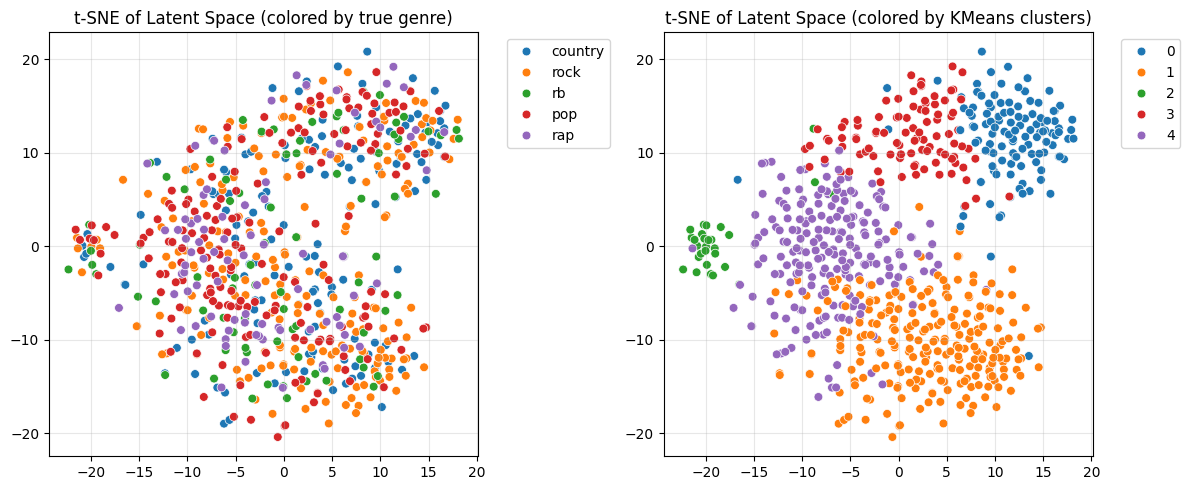

In [32]:
import umap
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
z_tsne = tsne.fit_transform(z_all)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=true_labels, palette="tab10", s=40)
plt.title("t-SNE of Latent Space (colored by true " + label_col + ")")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=kmeans_labels, palette="tab10", s=40)
plt.title("t-SNE of Latent Space (colored by KMeans clusters)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + "hard_task_tsne.png", dpi=300, bbox_inches="tight")
plt.show()

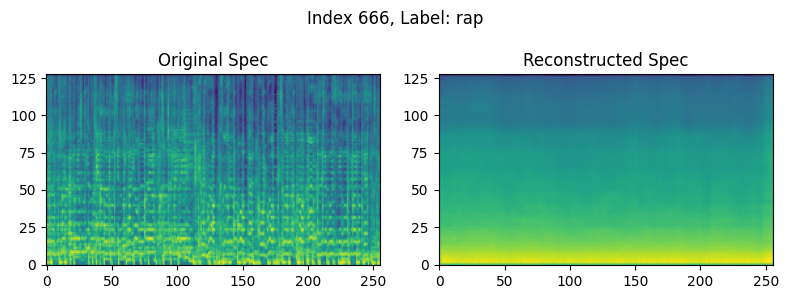

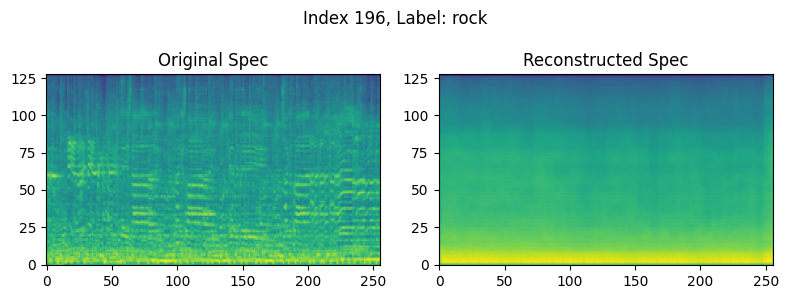

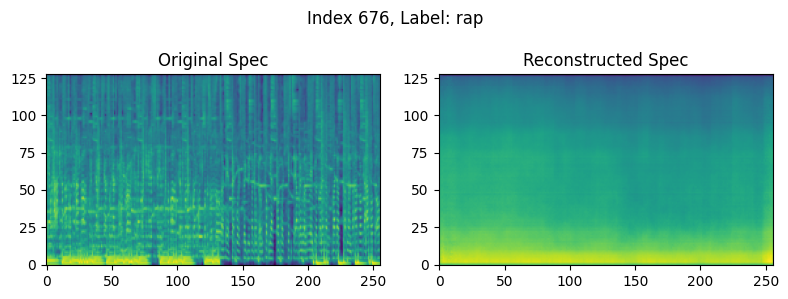

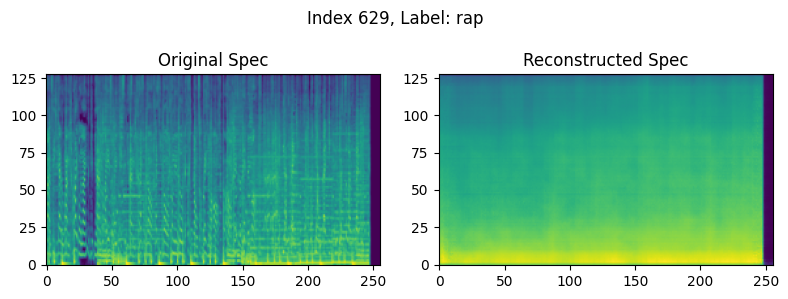

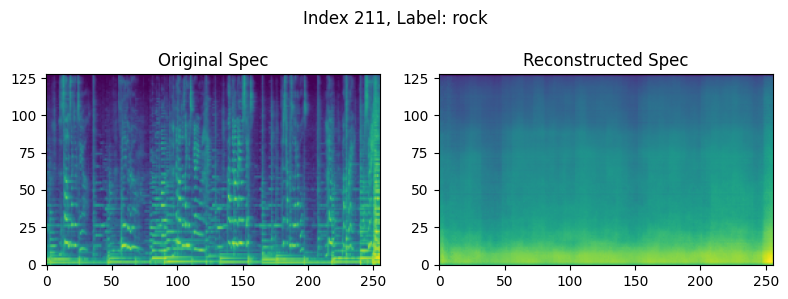

In [33]:
# Pick some random indices
n_examples = 5
idxs = np.random.choice(len(spec_norm), size=n_examples, replace=False)

for i in idxs:
    spec_in = spec_norm[i:i+1]
    lyr_in = lyrics_norm[i:i+1]
    cond_in = y_onehot[i:i+1]

    z_mean_i, z_log_var_i, z_i = encoder.predict([spec_in, lyr_in, cond_in], verbose=0)
    spec_recon_i, lyrics_recon_i = decoder.predict([z_i, cond_in], verbose=0)

    # Plot spectrogram original vs recon
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    axes[0].imshow(spec_in[0, :, :, 0], aspect="auto", origin="lower")
    axes[0].set_title("Original Spec")
    axes[1].imshow(spec_recon_i[0, :, :, 0], aspect="auto", origin="lower")
    axes[1].set_title("Reconstructed Spec")
    plt.suptitle(f"Index {i}, Label: {true_labels[i]}")
    plt.tight_layout()
    plt.show()


In [59]:
# ========================================
# CELL: Download Hard Task Results Folder
# ========================================
import os
import shutil
from google.colab import files

# ===== ENSURE RESULTS FOLDER EXISTS =====
results_folder_path = base_path + "results"
os.makedirs(results_folder_path, exist_ok=True)
print(f"✓ Results folder ready: {results_folder_path}")

# ===== AUTOMATICALLY SAVE ALL OUTPUTS =====
outputs_to_save = [
    "hard_task_training_curves.png",
    "hard_task_tsne.png",
    "hard_task_umap.png",
    "hard_task_clustering_metrics.csv",
    "hard_task_latent_z.npy"
]

# Move/copy all generated files to results folder
for filename in outputs_to_save:
    source_path = base_path + filename
    dest_path = os.path.join(results_folder_path, filename)
    if os.path.exists(source_path):
        shutil.copy2(source_path, dest_path)
        print(f"✓ Saved: {filename}")
    else:
        print(f"⚠️ Missing: {filename}")

# ===== CREATE ZIP ARCHIVE =====
output_zip_path = base_path + "hard_task_results_archive"
print(f"\nZipping folder: {results_folder_path} to {output_zip_path}.zip")

# Create zip archive
shutil.make_archive(output_zip_path, "zip", results_folder_path)

print(f"\n✓ Archive created: {output_zip_path}.zip")
print(f"✓ Size: {os.path.getsize(output_zip_path + '.zip') / (1024*1024):.1f} MB")
print("\n📥 Download your hard_task_results_archive.zip from the files sidebar.")

# Optional: Auto-download (uncomment if desired)
# files.download(output_zip_path + ".zip")


✓ Results folder ready: /content/results
✓ Saved: hard_task_training_curves.png
✓ Saved: hard_task_tsne.png
⚠️ Missing: hard_task_umap.png
✓ Saved: hard_task_clustering_metrics.csv
✓ Saved: hard_task_latent_z.npy

Zipping folder: /content/results to /content/hard_task_results_archive.zip

✓ Archive created: /content/hard_task_results_archive.zip
✓ Size: 1.7 MB

📥 Download your hard_task_results_archive.zip from the files sidebar.


In [60]:
print(comparison_results.to_string(index=False))

                   Method  Silhouette  Calinski-Harabasz  Davies-Bouldin      ARI      NMI   Purity
            PCA + K-Means    0.098510          84.551712        2.250144 0.019204 0.024391 0.335286
    Autoencoder + K-Means    0.214850         176.267410        1.472863 0.045030 0.071342 0.352855
Direct Spectral + K-Means    0.099595          82.263527        2.387783 0.015607 0.019992 0.335286
CVAE / Beta-VAE + K-Means    0.064905          40.385914        2.935002 0.006005 0.015581 0.316252
